In [1]:
import numpy as np
import tensorflow as tf
from keras.applications import InceptionResNetV2
from tensorflow import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2, os
from google.colab.patches import cv2_imshow

from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, Dropout

In [2]:
import collections
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


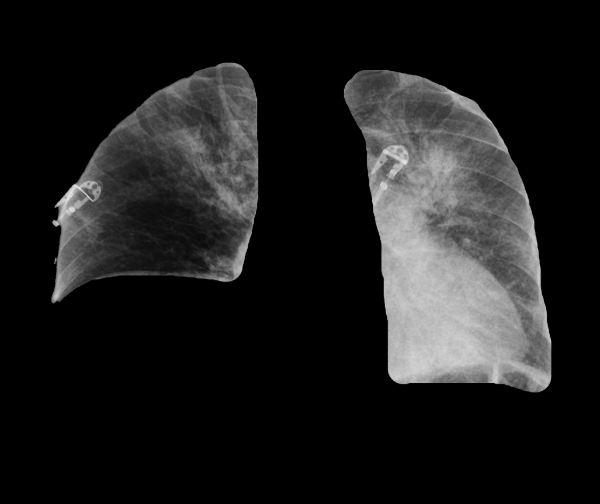

In [33]:
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input

img_path = '/content/drive/My Drive/FYP/test3.png'
# imgfile = '/COVID19(333).jpg'
#mfullpath = os.path.join(path_unproc, imgfile)
image = cv2.imread(img_path)
cv2_imshow(image)

In [4]:
def create_InceptionResNetV2():
  incepResNet = InceptionResNetV2(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
  #freeze all layers
  for layer in incepResNet.layers:
    layer.trainable = False
  x = incepResNet.output
  x = AveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(64,activation='relu')(x)
  final_layer = Dense(3,activation='softmax')(x)
  model = Model(inputs=incepResNet.input, outputs=final_layer)
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [5]:
model = create_InceptionResNetV2()
model.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
___________________________

In [6]:
last_conv_layer_name = "conv_7b_ac"
classifier_layer_names = ["average_pooling2d_1","flatten","dense", "dense_1"]

In [7]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=(299,299))
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [8]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    print(heatmap)
    return heatmap

In [34]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
# model = model_builder(weights="imagenet")

model.load_weights('/content/drive/My Drive/FYP/InceptionResNetV2/logs_finetune/V1_finetune')

# Print what the top predicted class is
preds = model.predict(img_array)

# print("Predicted:", decode_predictions(preds, top=1)[0])
print(preds)

#model.summary()

[[9.9727052e-01 6.2567682e-04 2.1037548e-03]]


In [10]:
y_pred = np.argmax(preds)
prob = preds[0][y_pred]*100
class_label = {0 : 'COVID19', 1: 'NORMAL', 2: 'PNEUMONIA'}
print('Prediction is {} with a probability of {}%'.format(class_label[y_pred],round(prob,2)))

Prediction is COVID19 with a probability of 99.98%


[[2.6888875e-03 4.6629550e-05 5.4554073e-03 9.2897173e-03 1.0933074e-02
  2.8891251e-03 2.9986700e-06 1.6784064e-03]
 [3.3454322e-03 2.2045432e-03 5.4278009e-02 2.4481395e-01 3.2086840e-01
  6.3091934e-02 1.4914707e-03 2.2956473e-03]
 [1.0708135e-01 2.6503411e-01 6.7403126e-01 5.1463789e-01 4.7941715e-01
  4.1163126e-01 1.7156248e-01 1.4749664e-02]
 [2.9777682e-01 9.4041902e-01 1.0000000e+00 4.9892423e-01 3.9136007e-01
  3.0720794e-01 3.8370940e-01 9.8383889e-02]
 [1.7305738e-01 6.1608589e-01 9.3134803e-01 5.4403573e-01 3.2084018e-01
  3.2319468e-01 6.1167020e-01 2.3072205e-01]
 [1.2709929e-02 7.4075018e-03 9.9221818e-02 1.3606557e-01 2.0077148e-01
  4.2586786e-01 4.4174799e-01 1.8064855e-01]
 [1.1248597e-03 2.4324141e-03 4.6322122e-03 4.0983297e-03 1.9604292e-02
  2.0810692e-02 3.1743996e-02 5.4689883e-03]
 [3.8642329e-03 8.7093888e-04 4.7160231e-04 1.2153846e-03 8.2162526e-03
  1.5986413e-02 5.9567862e-03 5.2802698e-03]]


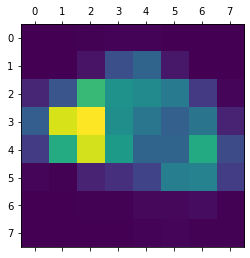

In [35]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

[[  0   0   1   2   2   0   0   0]
 [  0   0  13  62  81  16   0   0]
 [ 27  67 171 131 122 104  43   3]
 [ 75 239 255 127  99  78  97  25]
 [ 44 157 237 138  81  82 155  58]
 [  3   1  25  34  51 108 112  46]
 [  0   0   1   1   4   5   8   1]
 [  0   0   0   0   2   4   1   1]]


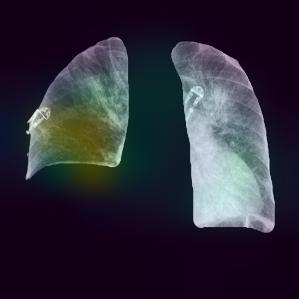

In [36]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)
img = cv2.resize(img,(299,299))

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)
print(heatmap)

# We use jet colormap to colorize heatmap
viridis = cm.get_cmap("viridis")

# We use RGB values of the colormap
viridis_colors = viridis(np.arange(256))[:, :3]
viridis_heatmap = viridis_colors[heatmap]

# We create an image with RGB colorized heatmap
viridis_heatmap = keras.preprocessing.image.array_to_img(viridis_heatmap)
viridis_heatmap = viridis_heatmap.resize((img.shape[1], img.shape[0]))
viridis_heatmap = keras.preprocessing.image.img_to_array(viridis_heatmap)

# Superimpose the heatmap on original image
superimposed_img = viridis_heatmap * 0.3 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "lungs_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
